## Transportation Notebook <br>~ Tobias Beidler-Shenk

This notebook will examine the strength of each neighborhood in terms of transportation, taking into account three variables: Public Transit systems, Driver friendliness and biking/walking. We will score each of the neighborhoods in terms of these variables, and come up with a combined transportation score for each neighborhood.

In [2]:
import pandas as pd
import numpy as np
import geopandas as geo
%matplotlib inline
import matplotlib.pyplot as plt

transportation = pd.read_csv('transportation.csv', index_col = "Neighborhood")
weights = pd.read_csv("weights.csv", index_col = "Timestamp")

# Public Transportation

First up: measuring the efficacy of a neighborhood's public transportation. We only used one column of data for this: the percentage of people who take public transportation to work. The more people who take it to work in a neighborhood, the stronger we consider that neighborhood's public transit routes to be, and so it receives a higher public transit score. Those scores are then multiplied by our public transportation "weight" that we received from the survey.

In [3]:
# Removes percentage signs, so we can order numerically:
count = 0
for x in transportation['Commute to Work: Public Transportation (2010)']:
    x = str(x).rstrip('%')
    transportation.iloc[count, 11] = float(x)
    count+=1

# Displays top 8 scores, after weight:
pt_scores = transportation.sort_values(by=['Commute to Work: Public Transportation (2010)'], ascending = False).iloc[0:, 11:12]
pt_scores["Public Transit Scores"] = np.nan
#transit_scale = 100/pt_scores.iloc[0,0]
for x in range (len(pt_scores)):
    pt_scores.iloc[x,1] = pt_scores.iloc[x,0] * weights.iloc[len(weights)-1, 0]
pt_scores.head(8)

,Commute to Work: Public Transportation (2010),Public Transit Scores
Neighborhood,,
Arlington Heights,88.9,386.255172
Northview Heights,77.4,336.289655
St. Clair,55,238.965517
Middle Hill,48.3,209.855172
Terrace Village,45.2,196.386207
Beltzhoover,43.1,187.262069
Manchester,41.7,181.179310
California-Kirkbride,41,178.137931


Using these scores, we can create a visual representation in geopandas to get a better idea of where our frontrunners are.

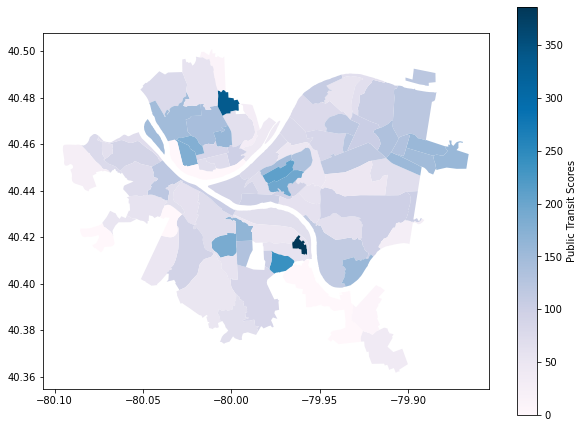

In [4]:
# Geopandas representation
scores1 = pt_scores.groupby("Neighborhood").sum()['Public Transit Scores']
neighborhoods = geo.read_file("Neighborhoods/Neighborhoods_.shp")
pt_map = neighborhoods.merge(scores1, how='left', left_on='hood', right_on='Neighborhood')
pt_map.plot(column='Public Transit Scores',
                  cmap='PuBu',
                  figsize=(10,7.5), 
                  legend=True,
                  legend_kwds={'label':"Public Transit Scores"}
                  )

It seems like there are a couple areas that are great for public transportation; maybe a lot of bus routes travel into these areas and so public transportation is the best option. There are also a lot of areas that aren't great for public transit, and they are often surrounded by other areas of similar scores, which makes sense."

# Driver Friendliness

Next, we look at how driver-friendly each neighborhood is. We take three variables into account here: the street density of each neighborhood (total length of streets for a given area), the percentage of people who drive to work, and the number of residential parking areas afforded to residents of the neighborhood.

In [5]:
# Street Density sorting
street_density = transportation.sort_values(by=['Street Density (st. mi/area sq. mi)'], ascending = False).iloc[0:, 4:5]
street_density.head(8)

,Street Density (st. mi/area sq. mi)
Neighborhood,
East Allegheny,71.8
Bluff,50.4
Central Business District,48.2
Knoxville,47.7
Central Northside,47.0
Bloomfield,45.2
North Shore,44.9
Middle Hill,43.5


In [6]:
# Driving Percentages sorting (removes percentage signs)
count = 0
for x in transportation['Commute to Work: Drive Alone (2010)']:
    x = str(x).rstrip('%')
    transportation.iloc[count, 9] = float(x)
    count+=1
driving_percentages = transportation.sort_values(by=['Commute to Work: Drive Alone (2010)'], ascending = False).iloc[0:, 9:10]
driving_percentages.head(8)

,Commute to Work: Drive Alone (2010)
Neighborhood,
East Carnegie,100
Summer Hill,94.6
New Homestead,88.9
Lincoln Place,83.9
Hays,81.9
Banksville,81.5
Ridgemont,80.4
Oakwood,78.4


In [7]:
# Parking areas sorting (adds up totals)
for x in range (len(transportation)):
    if (transportation.iloc[x, 7] == "None"):
        transportation.iloc[x, 7] = 0;
    else:
        transportation.iloc[x, 7] = len(str(transportation.iloc[x, 7]).split(','))
parking_available = transportation.sort_values(by=['Res. Permit Parking Area(s)'], ascending = False).iloc[0:, 7:8]
parking_available.head(8)

,Res. Permit Parking Area(s)
Neighborhood,
Shadyside,5
Squirrel Hill North,3
South Oakland,2
Mount Washington,2
West Oakland,2
Beechview,2
North Oakland,2
Bloomfield,2


It doesn't make sense to simply add these scores together to recieve a total driving score; for example, the most residential parking areas a neighborhood has is 5. Therefore, we need to scale these scores up relative to one another, so that they each occupy an equal part of the driving score. Then, we multiply the averaged scores by the "driving weight" from our survey to get final driving scores.

In [8]:
# Scales up the values so they each represent an equal part of the score (each out of 100, like percentages)
parking_scale = 100/parking_available.iloc[0]
density_scale = 100/street_density.iloc[0]
driving_scale = 100/driving_percentages.iloc[0]
for x in range (len(parking_available)):
    parking_available.iloc[x] = parking_available.iloc[x] * parking_scale
    street_density.iloc[x] = street_density.iloc[x] * density_scale
    driving_percentages.iloc[x] = driving_percentages.iloc[x] * driving_scale

# Averages the three values for each neighborhood (street density, parking areas available and driving percentages) 
# and multiplies the result by the weight from the survey
driving_scores = pd.concat([street_density, parking_available, driving_percentages], axis = 1, join='inner')
driving_scores["Driving Scores"] = np.nan 
for x in range(len(driving_scores)):
    driving_scores.iloc[x,3] = 0
    for y in range(3):
        driving_scores.iloc[x,3] += driving_scores.iloc[x,y]
    driving_scores.iloc[x,3] = (driving_scores.iloc[x,3]/3) * weights.iloc[len(weights)-1, 1]
    
# Displays top 8 scores, after weight and scaling:
driving_scores.sort_values(by=['Driving Scores'], ascending = False).head(8)

,Street Density (st. mi/area sq. mi),Res. Permit Parking Area(s),Commute to Work: Drive Alone (2010),Driving Scores
Neighborhood,,,,
Shadyside,41.225627,100,44.8,233.066590
East Allegheny,100.000000,20,44.3,205.847126
North Shore,62.534819,20,72,193.612589
Mount Washington,41.782730,40,65,183.900202
Crawford-Roberts,59.888579,20,65.4,182.028220
Bloomfield,62.952646,40,42,181.607338
South Oakland,52.646240,40,46.6,174.457932
Squirrel Hill North,30.222841,60,47.5,172.549307


Graphing these scores with Geopandas:

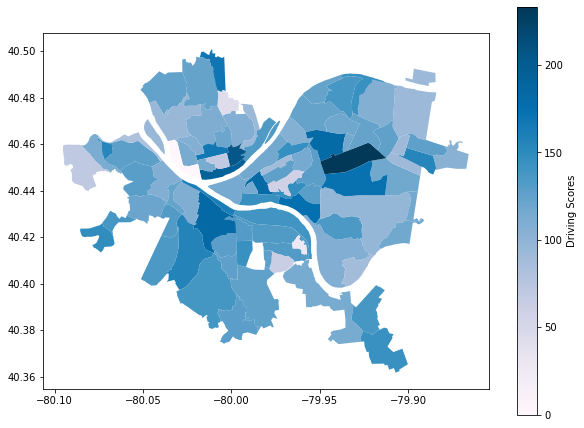

In [9]:
# Geopandas representation
scores2 = driving_scores.groupby("Neighborhood").sum()['Driving Scores']
neighborhoods = geo.read_file("Neighborhoods/Neighborhoods_.shp")
driving_map = neighborhoods.merge(scores2, how='left', left_on='hood', right_on='Neighborhood')
driving_map.plot(column='Driving Scores',
                  cmap='PuBu',
                  figsize=(10,7.5), 
                  legend=True,
                  legend_kwds={'label':"Driving Scores"}
                  )

Geopandas tells us that most neighborhoods are driving friendly and contain a lot of drivers. This is the result we expected; nearly every neighborhood is somewhat competent as far as drivability. Car owners are everywhere, and so it is really important that any given area can accomodate drivers. **Shadyside** ends up winning by a large margin, mainly due to the amount of residential parking it affords to its residents.

# Walking/Biking

The last factor for the transportation metric that we choose to look at is how good a neighborhood is for walkers/bikers. We take two variables into account here: firstly, the percentage of people who bike to work, and secondly the percentage of people who walk to work. We average these together, after scaling them proportionally to one another as we did for driving scores, and multiply them by the "walking/biking" weight from the survey. 

In [10]:
# Walking scores
count = 0
for x in transportation['Commute to Work: Walk (2010)']:
    x = str(x).rstrip('%')
    transportation.iloc[count, 15] = float(x)
    count+=1
walking = transportation.sort_values(by=['Commute to Work: Walk (2010)'], ascending = False).iloc[0:, 15:16]
walking.head(8)

,Commute to Work: Walk (2010)
Neighborhood,
Central Oakland,62.4
North Oakland,52.6
Allegheny Center,43.8
Bluff,43.1
Central Business District,42
West Oakland,40.8
Terrace Village,31.2
South Oakland,30.2


In [11]:
# Biking scores
count = 0
for x in transportation['Commute to Work: Bicycle (2010)']:
    x = str(x).rstrip('%')
    transportation.iloc[count, 14] = float(x)
    count+=1
biking = transportation.sort_values(by=['Commute to Work: Bicycle (2010)'], ascending = False).iloc[0:, 14:15]
biking.head(8)

,Commute to Work: Bicycle (2010)
Neighborhood,
Lower Lawrenceville,7.5
Bloomfield,6.4
Spring Hill-City View,6.3
Spring Garden,5.2
Friendship,4.9
Greenfield,3.1
Swisshelm Park,3.1
North Oakland,2.9


Again, we have to scale these columns so they each contribute equally to the score.

In [12]:
# Scales up the values for walking/biking so they each represent an equal part of the score:
walking_scale = 100/walking.iloc[0]
biking_scale = 100/biking.iloc[0]
for x in range (len(walking)):
    walking.iloc[x] = walking.iloc[x] * walking_scale
    biking.iloc[x] = biking.iloc[x] * biking_scale

# Averages the two values for each neighborhood (biking and walking percentages) and multiplies the result by the weight from the survey:
bw_scores = pd.concat([walking, biking], axis = 1, join='inner')
bw_scores["Biking/Walking Scores"] = np.nan 
for x in range(len(bw_scores)):
    bw_scores.iloc[x,2] = 0
    for y in range(2):
        bw_scores.iloc[x,2] += bw_scores.iloc[x,y]
    bw_scores.iloc[x,2] = (bw_scores.iloc[x,2]/2) * weights.iloc[len(weights)-1, 2]

# Displays the top 8 scores, after weight:
bw_scores.sort_values(by=['Biking/Walking Scores'], ascending = False).head(8)

,Commute to Work: Walk (2010),Commute to Work: Bicycle (2010),Biking/Walking Scores
Neighborhood,,,
North Oakland,84.2949,38.6667,266.416667
Lower Lawrenceville,21.9551,100,264.236111
Bloomfield,30.1282,85.3333,250.166667
Central Oakland,100,0,216.666667
Friendship,32.2115,65.3333,211.347222
Spring Hill-City View,7.05128,84,197.277778
Spring Garden,20.0321,69.3333,193.625000
Allegheny Center,70.1923,0,152.083333


Again, we take a look at the Geopandas visual for this metric:

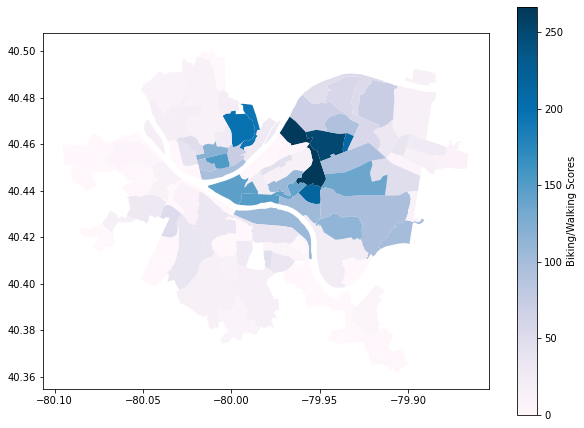

In [13]:
# Geopandas representation
scores3 = bw_scores.groupby("Neighborhood").sum()['Biking/Walking Scores']
neighborhoods = geo.read_file("Neighborhoods/Neighborhoods_.shp")
bw_map = neighborhoods.merge(scores3, how='left', left_on='hood', right_on='Neighborhood')
bw_map.plot(column='Biking/Walking Scores',
                  cmap='PuBu',
                  figsize=(10,7.5), 
                  legend=True,
                  legend_kwds={'label':"Biking/Walking Scores"}
                  )

Geopandas reveals that the communities that do a lot of biking/walking to work are connected to one another. The Oakland/Shadyside/Squirrel Hill areas seem to be at the center of all this, and **North Oakland** ends up winning.

# Combined Transportation Scoring

Now, we combine all three scores into one to make one big "transportation score". Because we have applied weights to each of the metrics, the metrics that scored higher in our survey will contribute more to the final scores. Below are the scores in addition to a geopandas graphic.

In [14]:
overall_scores = pd.concat([pt_scores.iloc[0:,1:2], driving_scores.iloc[0:,3:4], bw_scores.iloc[0:,2:3]], axis=1, join='inner')
overall_scores["Overall"] = np.nan
for x in range (len(overall_scores)):
    overall_scores.iloc[x,3] = 0
    for y in range (3):
        overall_scores.iloc[x,3] += overall_scores.iloc[x,y]
overall_scores = overall_scores.sort_values(by=['Overall'], ascending = False)
overall_scores.to_csv('transportation_scores.csv')
overall_scores.head(8)

,Public Transit Scores,Driving Scores,Biking/Walking Scores,Overall
Neighborhood,,,,
Bloomfield,86.896552,181.607338,250.166667,518.670557
Friendship,123.827586,117.268268,211.347222,452.443076
Lower Lawrenceville,79.075862,107.403371,264.236111,450.715345
North Oakland,49.965517,128.447110,266.416667,444.829294
Shadyside,116.875862,233.066590,94.736111,444.678563
Arlington Heights,386.255172,28.215480,0.000000,414.470653
Central Oakland,57.786207,129.516066,216.666667,403.968940
Northview Heights,336.289655,42.805699,19.791667,398.887021


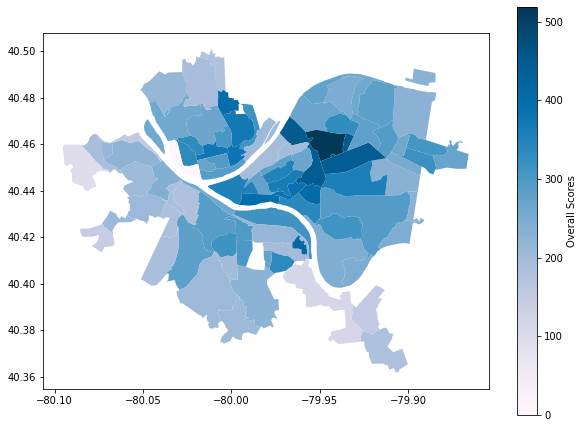

In [15]:
# Geopandas representation
final_scores = overall_scores.groupby("Neighborhood").sum()['Overall']
neighborhoods = geo.read_file("Neighborhoods/Neighborhoods_.shp")
final_map = neighborhoods.merge(final_scores, how='left', left_on='hood', right_on='Neighborhood')
final_map.plot(column='Overall',
                  cmap='PuBu',
                  figsize=(10,7.5), 
                  legend=True,
                  legend_kwds={'label':"Overall Scores"})

# Conclusions

Bloomfield, Friendship and Lower Lawrenceville take the top 3 places! Some other noteable results:
1. Arlington Heights and Northview Heights both place in the top 8 due to their very good transportation systems. However, they severely lack in other areas.
2. Although Bloomfield wins over friendship by quite a few points, an argument can be made that Friendship is more balanced overall (all three categories over 100)
3. For each individual category, our winners were:<br>
   __Public Transit:__ Arlington Heights<br>
   __Driving:__ Shadyside<br>
   __Walking/Biking:__ North Oakland